<a href="https://colab.research.google.com/github/Deadline430/SL_REPORT_2025/blob/main/US_Accidents_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare the packages for this project

In [ ]:
# --- Installation Commands ---
# Run these commands if you don't have the necessary packages installed in your environment.
!pip install --upgrade pandas scikit-learn matplotlib numpy plotly psutil scipy torch

# --- Import Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn # Import sklearn directly to get version
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, learning_curve, validation_curve, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, precision_recall_curve, auc
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pointbiserialr
import time
import platform
import psutil
import resource
import torch

print("\n--- Environment Information ---")
print(f"Python Version: {platform.python_version()}")
print(f"System: {platform.system()} {platform.release()}")
print(f"Processor: {platform.processor()}")
print(f"Total RAM: {round(psutil.virtual_memory().total / (1024**3), 2)} GB")


--- Environment Information ---
Python Version: 3.12.11
System: Linux 6.1.123+
Processor: x86_64
Total RAM: 50.99 GB


## View and Preprocessing the Dataset
### Dataset Overview


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/CS Master 2025/CS7641 Machine Learning/SL Report/Accident/US_Accidents_March23_1M_rows.csv')

### Data Cleaning and Handling Missing Values

In [ ]:
# Drop non-informative / leakage columns
drop_cols = [
    "End_Lat", "End_Lng",          # mostly null
    "Weather_Timestamp",           # often logged after the accident (leakage)
    "Description",                   # free text, not analyzed here
    "ID", "Source", "Street", "County", "Zipcode", "Airport_Code","City" # irrelevant features
]
df_clean = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Handle numeric weather fields
# Impute small % missing values with median
numeric_weather = ["Temperature(F)", "Humidity(%)", "Visibility(mi)",
                   "Wind_Speed(mph)", "Pressure(in)", "Wind_Chill(F)"]

for col in numeric_weather:
    if col in df_clean.columns:
        median_val = df_clean[col].median()
        df_clean[col] = df_clean[col].fillna(median_val)

# Special handling for Precipitation
if "Precipitation(in)" in df_clean.columns:
    # Treat NaN as 0 (no precipitation)
    df_clean["Precipitation(in)"] = df_clean["Precipitation(in)"].fillna(0)
    # Cap outlier value 9.99 -> 2.0 (more realistic maximum)
    df_clean.loc[df_clean["Precipitation(in)"] > 2.0, "Precipitation(in)"] = 2.0

# Handle boolean flags
bool_cols = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
             "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming",
             "Traffic_Signal", "Turning_Loop"]

for col in bool_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(False)

# Handle categorical fields
cat_cols = [ "Timezone", "Wind_Direction", "Weather_Condition", "Sunrise_Sunset", "Civil_Twilight",
            "Nautical_Twilight", "Astronomical_Twilight"]

for col in cat_cols:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna("Unknown")

# Duration cleanup
# Remove negative or zero durations (bad logs)
df_clean["Start_Time"] = pd.to_datetime(df_clean["Start_Time"], errors='coerce', format='mixed')
df_clean["End_Time"] = pd.to_datetime(df_clean["End_Time"], errors='coerce', format='mixed')
df_clean["Duration_min"] = (df_clean["End_Time"] - df_clean["Start_Time"]).dt.total_seconds() / 60

# Remove records with invalid durations (<0)
df_clean = df_clean[df_clean["Duration_min"] > 0]

# Cap extreme durations (>1440 minutes = 24h)
df_clean.loc[df_clean["Duration_min"] > 1440, "Duration_min"] = 1440

# ---- Step 7. Verify ----
print("Remaining missing values:", df_clean.isnull().sum().sum())
print("Final dataset shape:", df_clean.shape)

Remaining missing values: 0
Final dataset shape: (1000000, 36)


In [ ]:
df_clean['Hour'] = df_clean['Start_Time'].dt.hour
df_clean['Day_of_Week'] = df_clean['Start_Time'].dt.dayofweek  # Monday=0, Sunday=6
df_clean['Month'] = df_clean['Start_Time'].dt.month

hour_counts = df_clean['Hour'].value_counts().sort_index()
day_of_week_counts = df_clean['Day_of_Week'].value_counts().sort_index()
month_counts = df_clean['Month'].value_counts().sort_index()


In [ ]:
# Initialize df_clean_no_outliers with df_clean
df_clean_no_outliers = df_clean.copy()

# Remove outliers from 'Duration_min' using percentiles
lower_bound_duration = df_clean_no_outliers['Duration_min'].quantile(0.0005)
upper_bound_duration = df_clean_no_outliers['Duration_min'].quantile(0.9995)

df_clean_no_outliers = df_clean_no_outliers[(df_clean_no_outliers['Duration_min'] >= lower_bound_duration) & (df_clean_no_outliers['Duration_min'] <= upper_bound_duration)].copy()

print(f"Shape of data after removing duration outliers: {df_clean_no_outliers.shape}")

Shape of data after removing duration outliers: (999512, 39)


### Correlation Analysis

## Data Preprocessing And Split

#### Leakage Control & Feature Engineering

In [ ]:
# Drop 'End_Time' column for leakage control
if 'End_Time' in df_clean_no_outliers.columns:
    df_clean_no_outliers = df_clean_no_outliers.drop(columns=['End_Time'])
    print("Dropped 'End_Time' column from df_clean_no_outliers.")
else:
    print("'End_Time' column not found in df_clean_no_outliers.")

Dropped 'End_Time' column from df_clean_no_outliers.


In [ ]:
# Remove records with invalid durations (<0) and save to df_clean_no_outliers
df_clean_no_outliers = df_clean_no_outliers[df_clean_no_outliers["Duration_min"] > 0].copy()

print(f"Shape of data after removing non-positive durations: {df_clean_no_outliers.shape}")

Shape of data after removing non-positive durations: (999512, 38)


In [ ]:
# Select categorical columns
categorical_cols = df_clean.select_dtypes(include='object').columns

# Display the number of unique values for each categorical column
print("Number of unique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df_clean[col].nunique()}")

Number of unique values in categorical columns:
State: 49
Country: 1
Timezone: 5
Wind_Direction: 25
Weather_Condition: 119
Sunrise_Sunset: 3
Civil_Twilight: 3
Nautical_Twilight: 3
Astronomical_Twilight: 3


In [ ]:
from sklearn.model_selection import KFold

# Group 'Weather_Condition' into broader categories
def group_weather(condition):
    if isinstance(condition, str):
        condition = condition.lower()
        if 'clear' in condition or 'fair' in condition:
            return 'Clear'
        elif 'rain' in condition and 'snow' not in condition:
            return 'Rain'
        elif 'snow' in condition:
            return 'Snow'
        elif 'fog' in condition or 'mist' in condition:
            return 'Fog'
        elif 'storm' in condition or 'thunder' in condition:
            return 'Storm'
        else:
            return 'Other/Cloudy'
    return 'Unknown' # Handle potential non-string or missing values

# Start from df_clean_no_outliers
df_clean_encoded = df_clean_no_outliers.copy()

# Feature Engineering from Start_Time
df_clean_encoded['Hour'] = df_clean_encoded['Start_Time'].dt.hour
df_clean_encoded['Day_of_Week'] = df_clean_encoded['Start_Time'].dt.dayofweek  # Monday=0, Sunday=6
df_clean_encoded['Month'] = df_clean_encoded['Start_Time'].dt.month

# Cyclic Encoding for Hour
df_clean_encoded['Hour_sin'] = np.sin(2 * np.pi * df_clean_encoded['Hour'] / 24)
df_clean_encoded['Hour_cos'] = np.cos(2 * np.pi * df_clean_encoded['Hour'] / 24)

# Is_Weekend feature
df_clean_encoded['Is_Weekend'] = df_clean_encoded['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)

# Drop the original time columns after feature engineering
df_clean_encoded = df_clean_encoded.drop(columns=['Start_Time', 'Hour', 'Day_of_Week'])


df_clean_encoded['Weather_Category'] = df_clean_encoded['Weather_Condition'].apply(group_weather)

# One-Hot Encoding for Weather_Category and other categorical features (keeping Sunrise_Sunset for binary encoding in next cell)
categorical_cols_ohe = ['State', 'Country', 'Timezone', 'Wind_Direction', 'Civil_Twilight', 'Sunrise_Sunset','Nautical_Twilight', 'Astronomical_Twilight', 'Weather_Category']
df_clean_encoded = pd.get_dummies(df_clean_encoded, columns=categorical_cols_ohe, dummy_na=False)

# Drop the original 'Weather_Condition' column
df_clean_encoded = df_clean_encoded.drop(columns=['Weather_Condition'])

print("Shape of data after encoding and feature engineering (keeping Sunrise_Sunset one-hot encoded):", df_clean_encoded.shape)
display(df_clean_encoded.head())

Shape of data after encoding and feature engineering (keeping Sunrise_Sunset one-hot encoded): (999512, 127)


,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),...,Nautical_Twilight_Unknown,Astronomical_Twilight_Day,Astronomical_Twilight_Night,Astronomical_Twilight_Unknown,Weather_Category_Clear,Weather_Category_Fog,Weather_Category_Other/Cloudy,Weather_Category_Rain,Weather_Category_Snow,Weather_Category_Storm
0,2,44.987784,-117.895987,0.474,29.0,24.0,72.0,26.51,10.0,5.0,...,False,False,True,False,False,False,True,False,False,False
1,2,40.768687,-73.882166,0.357,77.0,77.0,58.0,29.85,10.0,15.0,...,False,True,False,False,False,False,False,True,False,False
2,3,29.438782,-98.477440,0.000,97.0,97.0,32.0,29.07,10.0,7.0,...,False,True,False,False,False,False,True,False,False,False
3,2,37.700647,-121.796590,0.986,73.0,73.0,39.0,29.56,10.0,17.0,...,False,True,False,False,True,False,False,False,False,False
4,2,39.926416,-75.144982,0.046,73.0,73.0,73.0,30.18,10.0,0.0,...,False,False,True,False,False,False,True,False,False,False


In [ ]:
# Convert boolean columns to integers (0 or 1)
bool_cols = df_clean_encoded.select_dtypes(include='bool').columns
for col in bool_cols:
    df_clean_encoded[col] = df_clean_encoded[col].astype(int)

print("Boolean columns converted to integers.")
display(df_clean_encoded[bool_cols].head())
print("\nData types after converting boolean columns:")
display(df_clean_encoded.info())

Boolean columns converted to integers.


,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,...,Nautical_Twilight_Unknown,Astronomical_Twilight_Day,Astronomical_Twilight_Night,Astronomical_Twilight_Unknown,Weather_Category_Clear,Weather_Category_Fog,Weather_Category_Other/Cloudy,Weather_Category_Rain,Weather_Category_Snow,Weather_Category_Storm
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0



Data types after converting boolean columns:
<class 'pandas.core.frame.DataFrame'>
Index: 999512 entries, 0 to 999999
Columns: 127 entries, Severity to Weather_Category_Storm
dtypes: float64(13), int32(1), int64(113)
memory usage: 972.3 MB


None

In [ ]:
from sklearn.preprocessing import StandardScaler

# Select the continuous weather columns to standardize
weather_cols_to_standardize = [
    "Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)",
    "Wind_Speed(mph)", "Precipitation(in)" # Removed Wind_Chill(F)
]

# Drop the highly correlated 'Wind_Chill(F)' column - This should ideally be done earlier, but keeping here for consistency with previous steps
if 'Wind_Chill(F)' in df_clean_encoded.columns:
    df_clean_encoded = df_clean_encoded.drop(columns=['Wind_Chill(F)'])
    print("Dropped 'Wind_Chill(F)' column due to high correlation with Temperature(F).")
else:
    print("'Wind_Chill(F)' column not found in the DataFrame.")

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standardization to the selected columns
# It's recommended to fit the scaler on the training data ONLY and then transform both train and test sets.
# For demonstration, applying to the whole dataframe here.
df_clean_scaled = df_clean_encoded.copy()
df_clean_scaled[weather_cols_to_standardize] = scaler.fit_transform(df_clean_scaled[weather_cols_to_standardize])

print("Data after standardizing weather metrics:")
display(df_clean_scaled[weather_cols_to_standardize].head())

Dropped 'Wind_Chill(F)' column due to high correlation with Temperature(F).
Data after standardizing weather metrics:


,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
0,-1.738942,0.315596,-3.027633,0.334894,-0.516357,-0.125896
1,0.812997,-0.305060,0.304419,0.334894,1.444312,-0.125896
2,1.876305,-1.457707,-0.473725,0.334894,-0.124223,-0.125896
3,0.600336,-1.147379,0.015110,0.334894,1.836445,-0.125896
4,0.600336,0.359928,0.633634,0.334894,-1.496691,-0.125896


In [ ]:
df_clean_scaled.shape
display(df_clean_scaled.info())

<class 'pandas.core.frame.DataFrame'>
Index: 999512 entries, 0 to 999999
Columns: 126 entries, Severity to Weather_Category_Storm
dtypes: float64(12), int32(1), int64(113)
memory usage: 964.6 MB


None

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
# Assuming 'Duration_min' is the target variable as clarified before
# and 'Severity' is used for stratification.
X = df_clean_scaled.drop(columns=['Duration_min']) # Drop target and time columns
y = df_clean_scaled['Duration_min']

# Stratify by 'Severity'
stratify_col = df_clean_scaled['Severity']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # 30% for testing
    random_state=42,  # Fixed random state for reproducibility
    stratify=stratify_col # Stratify by Severity
)


print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
print("\nDtype of X_train:", X_train.dtypes.unique())
print("Dtype of y_train:", y_train.dtypes)

Shape of X_train: (799609, 125)
Shape of X_test: (199903, 125)
Shape of y_train: (799609,)
Shape of y_test: (199903,)

Dtype of X_train: [dtype('int64') dtype('float64') dtype('int32')]
Dtype of y_train: float64


## Neural Network

## Define neural network architectures


In [ ]:
import torch.nn as nn

# 1. Define the shallow-wide neural network
class ShallowWideNN(nn.Module):
    def __init__(self, input_dim):
        super(ShallowWideNN, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 512)
        self.relu_1 = nn.ReLU()
        self.layer_2 = nn.Linear(512, 512)
        self.relu_2 = nn.ReLU()
        self.output_layer = nn.Linear(512, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.layer_2(x)
        x = self.relu_2(x)
        x = self.output_layer(x)
        return x

# 2. Define the deeper-narrower neural network
class DeeperNarrowerNN(nn.Module):
    def __init__(self, input_dim):
        super(DeeperNarrowerNN, self).__init__()
        self.layer_1 = nn.Linear(input_dim, 256)
        self.relu_1 = nn.ReLU()
        self.layer_2 = nn.Linear(256, 256)
        self.relu_2 = nn.ReLU()
        self.layer_3 = nn.Linear(256, 128)
        self.relu_3 = nn.ReLU()
        self.layer_4 = nn.Linear(128, 128)
        self.relu_4 = nn.ReLU()
        self.output_layer = nn.Linear(128, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.layer_2(x)
        x = self.relu_2(x)
        x = self.layer_3(x)
        x = self.relu_3(x)
        x = self.layer_4(x)
        x = self.relu_4(x)
        x = self.output_layer(x)
        return x

# Instantiate the models
input_dim = X_train.shape[1]
shallow_wide_model = ShallowWideNN(input_dim)
deeper_narrower_model = DeeperNarrowerNN(input_dim)

# Print model architectures and parameter counts
print("Shallow-Wide Model Architecture:")
print(shallow_wide_model)
print("\nDeeper-Narrower Model Architecture:")
print(deeper_narrower_model)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

shallow_wide_params = count_parameters(shallow_wide_model)
deeper_narrower_params = count_parameters(deeper_narrower_model)

print(f"\nShallow-Wide Model Parameters: {shallow_wide_params:,}")
print(f"Deeper-Narrower Model Parameters: {deeper_narrower_params:,}")

Shallow-Wide Model Architecture:
ShallowWideNN(
  (layer_1): Linear(in_features=125, out_features=512, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=512, out_features=512, bias=True)
  (relu_2): ReLU()
  (output_layer): Linear(in_features=512, out_features=1, bias=True)
)

Deeper-Narrower Model Architecture:
DeeperNarrowerNN(
  (layer_1): Linear(in_features=125, out_features=256, bias=True)
  (relu_1): ReLU()
  (layer_2): Linear(in_features=256, out_features=256, bias=True)
  (relu_2): ReLU()
  (layer_3): Linear(in_features=256, out_features=128, bias=True)
  (relu_3): ReLU()
  (layer_4): Linear(in_features=128, out_features=128, bias=True)
  (relu_4): ReLU()
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

Shallow-Wide Model Parameters: 327,681
Deeper-Narrower Model Parameters: 147,585


## Prepare data for pytorch



In [ ]:
# Convert pandas DataFrames/Series to NumPy arrays
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# Convert NumPy arrays to PyTorch tensors with float32 dtype
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1) # Add a dimension for the output
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)   # Add a dimension for the output

# Print shapes and data types
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_train_tensor dtype:", X_train_tensor.dtype)
print("X_test_tensor shape:", X_test_tensor.shape)
print("X_test_tensor dtype:", X_test_tensor.dtype)
print("y_train_tensor shape:", y_train_tensor.shape)
print("y_train_tensor dtype:", y_train_tensor.dtype)
print("y_test_tensor shape:", y_test_tensor.shape)
print("y_test_tensor dtype:", y_test_tensor.dtype)

X_train_tensor shape: torch.Size([799609, 125])
X_train_tensor dtype: torch.float32
X_test_tensor shape: torch.Size([199903, 125])
X_test_tensor dtype: torch.float32
y_train_tensor shape: torch.Size([799609, 1])
y_train_tensor dtype: torch.float32
y_test_tensor shape: torch.Size([199903, 1])
y_test_tensor dtype: torch.float32


## Implement training and evaluation functions


In [ ]:
import time
import psutil
import resource
import torch
import torch.nn as nn

def train_model(model, X_train, y_train, X_val, y_val, learning_rate, l2_lambda, batch_size, num_epochs, patience, device):
    """
    Trains a PyTorch regression model with SGD optimizer, MSE loss, L2 regularization,
    and early stopping. Tracks runtime and peak RAM usage.

    Args:
        model (torch.nn.Module): The PyTorch model to train.
        X_train (torch.Tensor): Training features tensor.
        y_train (torch.Tensor): Training target tensor.
        X_val (torch.Tensor): Validation features tensor.
        y_val (torch.Tensor): Validation target tensor.
        learning_rate (float): Learning rate for the optimizer.
        l2_lambda (float): L2 regularization strength (weight decay).
        batch_size (int): Batch size for training.
        num_epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs to wait for improvement before early stopping.
        device (torch.device): The device to use for training ('cuda' or 'cpu').

    Returns:
        tuple: A tuple containing:
            - list: History of training loss per epoch.
            - list: History of validation loss per epoch.
            - float: Runtime in seconds.
            - int: Peak RAM usage in bytes.
    """
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    criterion = nn.MSELoss() # Use MSE loss for regression

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    start_time = time.time()
    peak_ram = 0

    # Get the current process
    process = psutil.Process()

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0
        # Manual mini-batching
        permutation = torch.randperm(X_train.size(0))
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        for i in range(0, X_train.size(0), batch_size):
            batch_X = X_train_shuffled[i:i+batch_size].to(device)
            batch_y = y_train_shuffled[i:i+batch_size].to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * batch_X.size(0)

        avg_train_loss = total_train_loss / X_train.size(0)
        train_losses.append(avg_train_loss)

        # Evaluate on validation set
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for i in range(0, X_val.size(0), batch_size):
                batch_X_val = X_val[i:i+batch_size].to(device)
                batch_y_val = y_val[i:i+batch_size].to(device)
                outputs_val = model(batch_X_val)
                loss_val = criterion(outputs_val, batch_y_val)
                total_val_loss += loss_val.item() * batch_X_val.size(0)

        avg_val_loss = total_val_loss / X_val.size(0)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            # Optional: Save the best model state
            # torch.save(model.state_dict(), 'best_model.pth')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                break

        # Track peak RAM usage (using resource module for more accurate peak memory)
        peak_ram = max(peak_ram, resource.getrusage(resource.RUSAGE_SELF).ru_maxrss)


    end_time = time.time()
    runtime = end_time - start_time

    # Convert peak_ram from kilobytes to bytes if resource.getrusage returns KB

    if platform.system() == "Linux": # resource.RUSAGE_SELF.ru_maxrss is in KB on Linux
         peak_ram *= 1024

    return train_losses, val_losses, runtime, peak_ram

def evaluate_model(model, X_test, y_test, batch_size, device):
    """
    Evaluates a PyTorch regression model on a test set.

    Args:
        model (torch.nn.Module): The PyTorch model to evaluate.
        X_test (torch.Tensor): Test features tensor.
        y_test (torch.Tensor): Test target tensor.
        batch_size (int): Batch size for evaluation.
        device (torch.device): The device to use for evaluation ('cuda' or 'cpu').

    Returns:
        float: The MSE loss on the test set.
    """
    model.to(device)
    model.eval()  # Set model to evaluation mode
    criterion = nn.MSELoss()
    total_test_loss = 0
    with torch.no_grad():
        for i in range(0, X_test.size(0), batch_size):
            batch_X_test = X_test[i:i+batch_size].to(device)
            batch_y_test = y_test[i:i+batch_size].to(device)
            outputs_test = model(batch_X_test)
            loss_test = criterion(outputs_test, batch_y_test)
            total_test_loss += loss_test.item() * batch_X_test.size(0)

    avg_test_loss = total_test_loss / X_test.size(0)
    print(f'Test Loss: {avg_test_loss:.4f}')
    return avg_test_loss

print("Defined train_model and evaluate_model functions.")

Defined train_model and evaluate_model functions.


In [ ]:
# 1. Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Set the hyperparameters
learning_rate = 0.001 # Within the specified range (e.g., 1e-4 to 1e-3)
l2_lambda = 0.0001    # Within the specified range (e.g., 1e-4 to 1e-3)
batch_size = 1024     # Within the specified range (e.g., 512 to 2048)
num_epochs = 15       # Maximum number of epochs as specified
patience = 3          # Patience for early stopping as specified

print(f"\nHyperparameters:")
print(f"  Learning Rate: {learning_rate}")
print(f"  L2 Lambda: {l2_lambda}")
print(f"  Batch Size: {batch_size}")
print(f"  Number of Epochs: {num_epochs}")
print(f"  Patience: {patience}")

# 3. Instantiate the shallow-wide model again (need new instances for training)
input_dim = X_train_tensor.shape[1]
shallow_wide_model = ShallowWideNN(input_dim)
print("\nInstantiated Shallow-Wide Model.")

# 4. Train the shallow-wide model
print("\nTraining Shallow-Wide Model...")
# Use X_test_tensor and y_test_tensor as validation for simplicity as per previous steps
shallow_wide_train_losses, shallow_wide_val_losses, shallow_wide_runtime, shallow_wide_peak_ram = train_model(
    shallow_wide_model,
    X_train_tensor,
    y_train_tensor_scaled, # Use scaled target
    X_test_tensor,
    y_test_tensor_scaled,  # Use scaled target
    learning_rate,
    l2_lambda,
    batch_size,
    num_epochs,
    patience,
    device
)
print("Finished training Shallow-Wide Model.")

# 5. Instantiate the deeper-narrower model again (need new instances for training)
deeper_narrower_model = DeeperNarrowerNN(input_dim)
print("\nInstantiated Deeper-Narrower Model.")

# 6. Train the deeper-narrower model
print("\nTraining Deeper-Narrower Model...")
# Use X_test_tensor and y_test_tensor as validation for simplicity as per previous steps
deeper_narrower_train_losses, deeper_narrower_val_losses, deeper_narrower_runtime, deeper_narrower_peak_ram = train_model(
    deeper_narrower_model,
    X_train_tensor,
    y_train_tensor_scaled, # Use scaled target
    X_test_tensor,
    y_test_tensor_scaled,  # Use scaled target
    learning_rate,
    l2_lambda,
    batch_size,
    num_epochs,
    patience,
    device
)
print("Finished training Deeper-Narrower Model.")


# 7. Call the evaluate_model function for both models
print("\nEvaluating Shallow-Wide Model on Test Set...")
shallow_wide_test_loss = evaluate_model(shallow_wide_model, X_test_tensor, y_test_tensor_scaled, batch_size, device)

print("\nEvaluating Deeper-Narrower Model on Test Set...")
deeper_narrower_test_loss = evaluate_model(deeper_narrower_model, X_test_tensor, y_test_tensor_scaled, batch_size, device)

# 8. Print the recorded results
print("\n--- Training and Evaluation Results ---")
print("Shallow-Wide Model:")
print(f"  Runtime: {shallow_wide_runtime:.2f} seconds")
print(f"  Peak RAM Usage: {shallow_wide_peak_ram / (1024**2):.2f} MB") # Convert bytes to MB for readability
print(f"  Test Loss (MSE): {shallow_wide_test_loss:.4f}")

print("\nDeeper-Narrower Model:")
print(f"  Runtime: {deeper_narrower_runtime:.2f} seconds")
print(f"  Peak RAM Usage: {deeper_narrower_peak_ram / (1024**2):.2f} MB") # Convert bytes to MB for readability
print(f"  Test Loss (MSE): {deeper_narrower_test_loss:.4f}")


Using device: cuda

Hyperparameters:
  Learning Rate: 0.001
  L2 Lambda: 0.0001
  Batch Size: 1024
  Number of Epochs: 15
  Patience: 3

Instantiated Shallow-Wide Model.

Training Shallow-Wide Model...
Epoch [1/15], Train Loss: 1.2036, Val Loss: 1.0026
Epoch [2/15], Train Loss: 0.9790, Val Loss: 0.9964
Epoch [3/15], Train Loss: 0.9730, Val Loss: 0.9900
Epoch [4/15], Train Loss: 0.9693, Val Loss: 0.9905
Epoch [5/15], Train Loss: 0.9670, Val Loss: 0.9894
Epoch [6/15], Train Loss: 0.9649, Val Loss: 0.9818
Epoch [7/15], Train Loss: 0.9654, Val Loss: 0.9770
Epoch [8/15], Train Loss: 0.9639, Val Loss: 0.9772
Epoch [9/15], Train Loss: 0.9615, Val Loss: 0.9748
Epoch [10/15], Train Loss: 0.9605, Val Loss: 0.9937
Epoch [11/15], Train Loss: 0.9589, Val Loss: 0.9702
Epoch [12/15], Train Loss: 0.9588, Val Loss: 0.9777
Epoch [13/15], Train Loss: 0.9568, Val Loss: 0.9898
Epoch [14/15], Train Loss: 0.9569, Val Loss: 0.9698
Epoch [15/15], Train Loss: 0.9557, Val Loss: 0.9657
Finished training Shallow-W

## Generate learning curve data




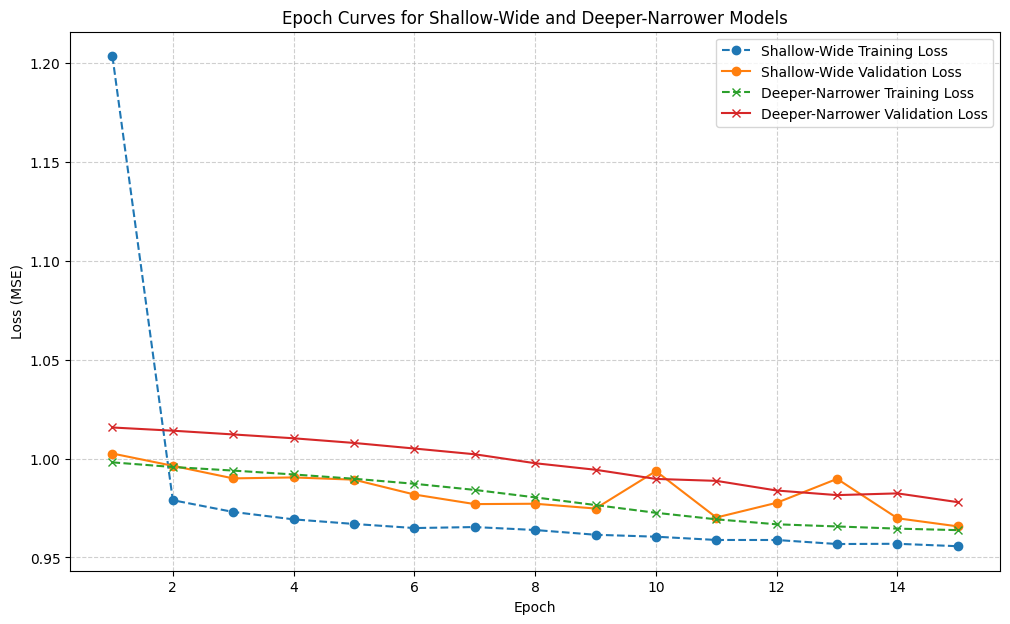

Generated epoch curves plot.


In [ ]:
# Plot epoch curves for both models
plt.figure(figsize=(12, 7))

# Shallow-Wide Model Epoch Curve
epochs_sw = range(1, len(shallow_wide_train_losses) + 1)
plt.plot(epochs_sw, shallow_wide_train_losses, label='Shallow-Wide Training Loss', marker='o', linestyle='--')
plt.plot(epochs_sw, shallow_wide_val_losses, label='Shallow-Wide Validation Loss', marker='o', linestyle='-')
# Mark early stopping point for Shallow-Wide
if len(shallow_wide_train_losses) < num_epochs: # Early stopping occurred
    plt.axvline(x=len(shallow_wide_train_losses), color='red', linestyle=':', label='Shallow-Wide Early Stop')

# Deeper-Narrower Model Epoch Curve
epochs_dn = range(1, len(deeper_narrower_train_losses) + 1)
plt.plot(epochs_dn, deeper_narrower_train_losses, label='Deeper-Narrower Training Loss', marker='x', linestyle='--')
plt.plot(epochs_dn, deeper_narrower_val_losses, label='Deeper-Narrower Validation Loss', marker='x', linestyle='-')
# Mark early stopping point for Deeper-Narrower
if len(deeper_narrower_train_losses) < num_epochs: # Early stopping occurred
     plt.axvline(x=len(deeper_narrower_train_losses), color='purple', linestyle=':', label='Deeper-Narrower Early Stop')


plt.title('Epoch Curves for Shallow-Wide and Deeper-Narrower Models')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Generated epoch curves plot.")

In [ ]:
# Define the training set sizes for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)
# Convert fractions to absolute numbers of samples
train_sizes_abs = (train_sizes * len(X_train_tensor)).astype(int)

print("Training set sizes for learning curve (absolute):", train_sizes_abs)

# Initialize lists to store losses for plotting for both models
shallow_wide_train_loss_history = []
shallow_wide_val_loss_history = []
deeper_narrower_train_loss_history = []
deeper_narrower_val_loss_history = []


# Define hyperparameters (same as before)
learning_rate = 0.001
l2_lambda = 0.0001
batch_size = 1024
num_epochs = 15
patience = 3
input_dim = X_train_tensor.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print("\nGenerating data for Learning Curve (using both models):")
# Iterate through the defined training set sizes
for train_size in train_sizes_abs:
    print(f"\nTraining on subset size: {train_size}")

    # Create a subset of the training data
    # Use random sampling for simplicity
    indices = torch.randperm(len(X_train_tensor))[:train_size]
    X_train_subset = X_train_tensor[indices]
    y_train_subset_scaled = y_train_tensor_scaled[indices]

    # --- Shallow-Wide Model ---
    print("  Training Shallow-Wide Model...")
    # Instantiate a new Shallow-Wide model for each training size
    shallow_wide_model = ShallowWideNN(input_dim)

    # Train the model on the current subset
    current_train_losses_sw, current_val_losses_sw, _, _ = train_model(
        shallow_wide_model,
        X_train_subset,
        y_train_subset_scaled,
        X_test_tensor, # Validation set
        y_test_tensor_scaled, # Validation target
        learning_rate,
        l2_lambda,
        batch_size,
        num_epochs,
        patience,
        device
    )

    # Store the final training loss and the best validation loss
    final_train_loss_sw = current_train_losses_sw[-1] # Assuming the last recorded loss is the final one
    best_val_loss_sw = min(current_val_losses_sw)

    shallow_wide_train_loss_history.append(final_train_loss_sw)
    shallow_wide_val_loss_history.append(best_val_loss_sw)

    print(f"    Shallow-Wide Model: Final Train Loss: {final_train_loss_sw:.4f}, Best Val Loss: {best_val_loss_sw:.4f}")


    # --- Deeper-Narrower Model ---
    print("  Training Deeper-Narrower Model...")
    # Instantiate a new Deeper-Narrower model for each training size
    deeper_narrower_model = DeeperNarrowerNN(input_dim)

    # Train the model on the current subset
    current_train_losses_dn, current_val_losses_dn, _, _ = train_model(
        deeper_narrower_model,
        X_train_subset,
        y_train_subset_scaled,
        X_test_tensor, # Validation set
        y_test_tensor_scaled, # Validation target
        learning_rate,
        l2_lambda,
        batch_size,
        num_epochs,
        patience,
        device
    )

    # Store the final training loss and the best validation loss
    final_train_loss_dn = current_train_losses_dn[-1] # Assuming the last recorded loss is the final one
    best_val_loss_dn = min(current_val_losses_dn)

    deeper_narrower_train_loss_history.append(final_train_loss_dn)
    deeper_narrower_val_loss_history.append(best_val_loss_dn)

    print(f"    Deeper-Narrower Model: Final Train Loss: {final_train_loss_dn:.4f}, Best Val Loss: {best_val_loss_dn:.4f}")


# Store the collected data points for both models
learning_curve_data_sw = {
    'train_sizes': train_sizes_abs,
    'train_losses': shallow_wide_train_loss_history,
    'val_losses': shallow_wide_val_loss_history
}

learning_curve_data_dn = {
    'train_sizes': train_sizes_abs,
    'train_losses': deeper_narrower_train_loss_history,
    'val_losses': deeper_narrower_val_loss_history
}


# Print the collected data points
print("\nCollected Learning Curve Data (Shallow-Wide Model):")
print(learning_curve_data_sw)

print("\nCollected Learning Curve Data (Deeper-Narrower Model):")
print(learning_curve_data_dn)

Training set sizes for learning curve (absolute): [ 79960 159921 239882 319843 399804 479765 559726 639687 719648 799609]

Generating data for Learning Curve (using both models):

Training on subset size: 79960
  Training Shallow-Wide Model...
Epoch [1/15], Train Loss: 3.4291, Val Loss: 1.0239
Epoch [2/15], Train Loss: 1.0130, Val Loss: 1.0202
Epoch [3/15], Train Loss: 1.0110, Val Loss: 1.0277
Epoch [4/15], Train Loss: 1.0094, Val Loss: 1.0251
Epoch [5/15], Train Loss: 1.0077, Val Loss: 1.0153
Epoch [6/15], Train Loss: 1.0062, Val Loss: 1.0126
Epoch [7/15], Train Loss: 1.0048, Val Loss: 1.0137
Epoch [8/15], Train Loss: 1.0038, Val Loss: 1.0100
Epoch [9/15], Train Loss: 1.0025, Val Loss: 1.0349
Epoch [10/15], Train Loss: 1.0020, Val Loss: 1.0091
Epoch [11/15], Train Loss: 1.0008, Val Loss: 1.0075
Epoch [12/15], Train Loss: 1.0000, Val Loss: 1.0068
Epoch [13/15], Train Loss: 0.9990, Val Loss: 1.0137
Epoch [14/15], Train Loss: 0.9985, Val Loss: 1.0045
Epoch [15/15], Train Loss: 0.9974, Va

## Generate model complexity curve data


In [ ]:
# 1. Select a hyperparameter to vary: l2_lambda
# 2. Define a list of different values for l2_lambda
l2_lambda_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# 3. Initialize lists to store validation losses for both models
complexity_val_losses_sw = []
complexity_val_losses_dn = []

# 4. Choose the neural network architectures to use: both Shallow-Wide and Deeper-Narrower NNs.
# Use the same hyperparameters as before for consistency, except for the varied one
learning_rate = 0.001
batch_size = 1024
num_epochs = 15
patience = 3
input_dim = X_train_tensor.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 8. Print a message indicating that data generation is starting
print("Generating data for Model Complexity Curve (varying L2 Lambda for both models):")

# 9. Iterate through the list of hyperparameter values
for l2_lambda in l2_lambda_values:
    # a. Print the current hyperparameter value
    print(f"\nTraining with l2_lambda: {l2_lambda}")

    # b. For the Shallow-Wide Model:
    print("  Training Shallow-Wide Model...")
    # i. Instantiate a *new* instance of the chosen neural network model
    shallow_wide_model = ShallowWideNN(input_dim)

    # ii. Train the model using the train_model function
    # Use the full training data and the validation data
    current_train_losses_sw, current_val_losses_sw, _, _ = train_model(
        shallow_wide_model,
        X_train_tensor,
        y_train_tensor_scaled,  # Use scaled target
        X_test_tensor,
        y_test_tensor_scaled,   # Use scaled target
        learning_rate,
        l2_lambda,  # Use the current l2_lambda value
        batch_size,
        num_epochs,
        patience,
        device
    )

    # iii. Record the *best* validation loss
    # The best validation loss is the minimum value achieved during training
    best_val_loss_sw = min(current_val_losses_sw)

    # iv. Append the best validation loss to the list
    complexity_val_losses_sw.append(best_val_loss_sw)

    # v. Print the l2_lambda value and the best validation loss
    print(f"    Shallow-Wide Model: l2_lambda: {l2_lambda}, Best Val Loss: {best_val_loss_sw:.4f}")


    # c. For the Deeper-Narrower Model:
    print("  Training Deeper-Narrower Model...")
    # i. Instantiate a *new* instance of the chosen neural network model
    deeper_narrower_model = DeeperNarrowerNN(input_dim)

    # ii. Train the model using the train_model function
    current_train_losses_dn, current_val_losses_dn, _, _ = train_model(
        deeper_narrower_model,
        X_train_tensor,
        y_train_tensor_scaled,  # Use scaled target
        X_test_tensor,
        y_test_tensor_scaled,   # Use scaled target
        learning_rate,
        l2_lambda,  # Use the current l2_lambda value
        batch_size,
        num_epochs,
        patience,
        device
    )

    # iii. Record the *best* validation loss
    best_val_loss_dn = min(current_val_losses_dn)

    # iv. Append the best validation loss to the list
    complexity_val_losses_dn.append(best_val_loss_dn)

    # v. Print the l2_lambda value and the best validation loss
    print(f"    Deeper-Narrower Model: l2_lambda: {l2_lambda}, Best Val Loss: {best_val_loss_dn:.4f}")


# 10. Store the collected data points for both models
complexity_curve_data_sw = {
    'l2_lambda_values': l2_lambda_values,
    'val_losses': complexity_val_losses_sw
}

complexity_curve_data_dn = {
    'l2_lambda_values': l2_lambda_values,
    'val_losses': complexity_val_losses_dn
}

# 11. Print both collected complexity curve data dictionaries
print("\nCollected Model Complexity Curve Data (Shallow-Wide Model):")
print(complexity_curve_data_sw)

print("\nCollected Model Complexity Curve Data (Deeper-Narrower Model):")
print(complexity_curve_data_dn)

Generating data for Model Complexity Curve (varying L2 Lambda for both models):

Training with l2_lambda: 1e-05
  Training Shallow-Wide Model...
Epoch [1/15], Train Loss: 1.2119, Val Loss: 1.0033
Epoch [2/15], Train Loss: 0.9802, Val Loss: 0.9954
Epoch [3/15], Train Loss: 0.9741, Val Loss: 0.9937
Epoch [4/15], Train Loss: 0.9695, Val Loss: 0.9872
Epoch [5/15], Train Loss: 0.9661, Val Loss: 0.9827
Epoch [6/15], Train Loss: 0.9640, Val Loss: 0.9800
Epoch [7/15], Train Loss: 0.9629, Val Loss: 0.9783
Epoch [8/15], Train Loss: 0.9621, Val Loss: 0.9778
Epoch [9/15], Train Loss: 0.9603, Val Loss: 0.9811
Epoch [10/15], Train Loss: 0.9598, Val Loss: 0.9726
Epoch [11/15], Train Loss: 0.9586, Val Loss: 0.9710
Epoch [12/15], Train Loss: 0.9582, Val Loss: 0.9697
Epoch [13/15], Train Loss: 0.9564, Val Loss: 0.9684
Epoch [14/15], Train Loss: 0.9556, Val Loss: 0.9685
Epoch [15/15], Train Loss: 0.9546, Val Loss: 0.9787
    Shallow-Wide Model: l2_lambda: 1e-05, Best Val Loss: 0.9684
  Training Deeper-Na

## Analyze and visualize results



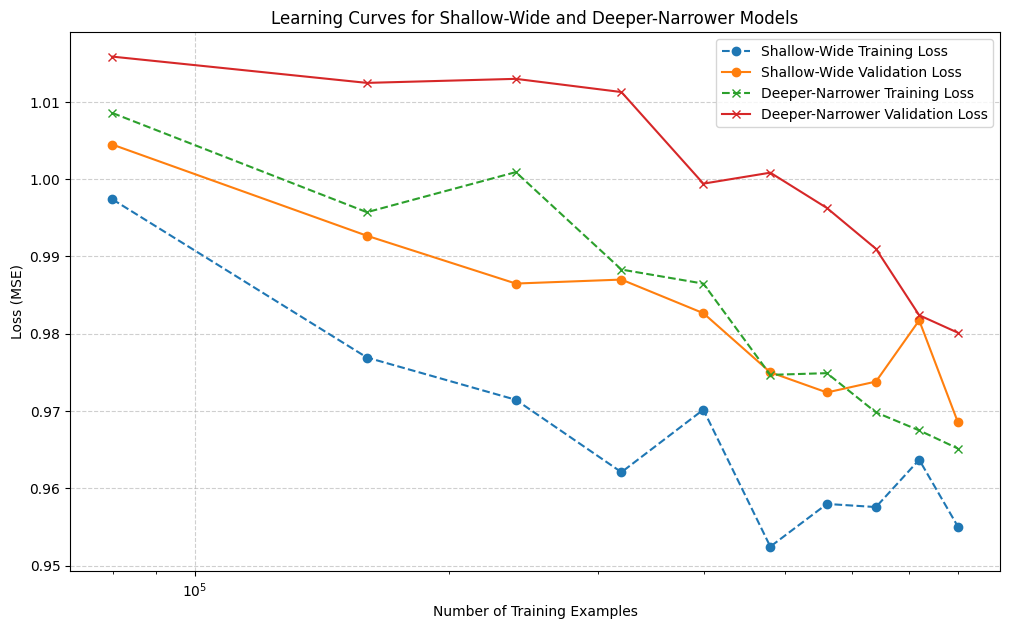

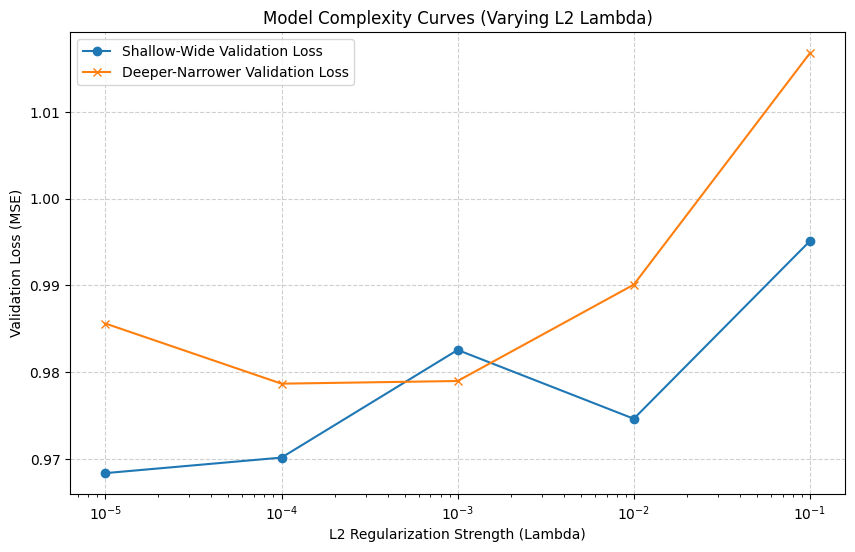


--- Performance and Resource Usage Summary ---
Shallow-Wide Model:
  Runtime: 30.85 seconds
  Peak RAM Usage: 15861.64 MB
  Test Loss (MSE): 0.9657

Deeper-Narrower Model:
  Runtime: 35.09 seconds
  Peak RAM Usage: 15861.64 MB
  Test Loss (MSE): 0.9780


In [ ]:
import matplotlib.pyplot as plt

# 1. Create a single plot for the learning curves of both models
plt.figure(figsize=(12, 7))
plt.plot(learning_curve_data_sw['train_sizes'], learning_curve_data_sw['train_losses'], label='Shallow-Wide Training Loss', marker='o', linestyle='--')
plt.plot(learning_curve_data_sw['train_sizes'], learning_curve_data_sw['val_losses'], label='Shallow-Wide Validation Loss', marker='o', linestyle='-')
plt.plot(learning_curve_data_dn['train_sizes'], learning_curve_data_dn['train_losses'], label='Deeper-Narrower Training Loss', marker='x', linestyle='--')
plt.plot(learning_curve_data_dn['train_sizes'], learning_curve_data_dn['val_losses'], label='Deeper-Narrower Validation Loss', marker='x', linestyle='-')

plt.title('Learning Curves for Shallow-Wide and Deeper-Narrower Models')
plt.xlabel("Number of Training Examples")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xscale('log') # Use log scale for training size for better visualization
plt.show()

# 2. Create a single plot for the model complexity curves of both models
plt.figure(figsize=(10, 6))
plt.plot(complexity_curve_data_sw['l2_lambda_values'], complexity_curve_data_sw['val_losses'], marker='o', label='Shallow-Wide Validation Loss')
plt.plot(complexity_curve_data_dn['l2_lambda_values'], complexity_curve_data_dn['val_losses'], marker='x', label='Deeper-Narrower Validation Loss')

plt.xscale('log') # Use log scale for L2 lambda values
plt.title('Model Complexity Curves (Varying L2 Lambda)')
plt.xlabel("L2 Regularization Strength (Lambda)")
plt.ylabel("Validation Loss (MSE)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 3. Print a summary of the performance metrics
print("\n--- Performance and Resource Usage Summary ---")
print("Shallow-Wide Model:")
print(f"  Runtime: {shallow_wide_runtime:.2f} seconds")
print(f"  Peak RAM Usage: {shallow_wide_peak_ram / (1024**2):.2f} MB")
print(f"  Test Loss (MSE): {shallow_wide_test_loss:.4f}")

print("\nDeeper-Narrower Model:")
print(f"  Runtime: {deeper_narrower_runtime:.2f} seconds")
print(f"  Peak RAM Usage: {deeper_narrower_peak_ram / (1024**2):.2f} MB")
print(f"  Test Loss (MSE): {deeper_narrower_test_loss:.4f}")
